# Variable Time Normalization Analysis For Reaction Rates
<center>
    <img src="images/1orderrxn.png" width=300 align="center">      
</center>

## Jupyter Notebook Intro
Ipython Notebooks are an excellent way to perform visual data analysis because they allow formatted text, code, and the code's output to exist side by side in the same document. Each of these components are grouped in boxes called **cells**, which are handy organizational tools that also make the notebook highly interactive. For example, a user might run a code cell that plots some data, inspect the date in the output cell that appears below it. If they want to tweak the plot, they can alter the code cell and re-run it without having to re-run any of the preceding cells. This modular design makes it easy to iterate quickly on data visualizations and analysis. 

### Cell Types
The most common cell types are *code cells* and *markdown cells*. **Markdown cells**, like the one you are currently reading, allow the notebook author to format text using a simple markdown language, providing context, narrative, and/or instruction for the code cells in the notebook. **Code cells** are prefixed with a <span style="color: gray;">[ ]:</span> and have special syntax highlighting to make the python code more readable and debuggable. When run, the cell prefix will look something like <span style="color: gray;">[1]:</span>, where the integer in brackets indicates the order in which cells were run. This occasionally comes in handy when cells are dependent on each other. 

### Running Cells
To run a cell, simply click it to highlight it, and then press **SHIFT+ENTER** on your keyboard, or click the "Play" button in the toolbar above the document. When cells execute, if they have any output to display, that output will appear in an output cell directly below the code. Furthermore, any variables defined in a cell are stored in memory until the ipython notebook kernel is restarted. If a cell freezes during execution, you can force it to stop by clicking the "Stop" (square) button above the document. If you would like to overwrite data or variables that have already been defined by running a code cell, simply rerun that code cell with the new data or click the "Restart" button (a cyclic arrow) above the document to completely restart the document's python interpreter and clear the memory. 

## How to Use this Notebook
This notebook is designed to be run from top to bottom in order to perform VTNA analysis on reaction profiles obtained with Mass Spectrometry or NMR. 

* Keep this notebook in a folder that also contains the **vtna_helper.py** file. This file defines the functions used in this notebook.
    
* Run each cell in order, paying attention to the markdown instructions above the code, if it exists.

* When prompted in the markdown, add the local file path to the data (an excel file) that you want to analyze. The path may be absolute or relative to this document. 

* Visualize your data using the following cells, and use the slider wdgets that appear to perform VTNA. 

### 0. Import necessary helper functions

In [17]:
from vtna_helper import *
import ipywidgets as widgets
from ipywidgets import interactive
import matplotlib.pyplot as plt

### 1a. Add path to Data (USER INPUT REQUIRED)

In [2]:
filename = "../../static/sampledata/Hydroamination-Kinetics-Catalyst-Order.xlsx"

### 1b. Import Data

In [3]:
raw_data, sheet_names, rct_labels = load_raw(filename)
print(
    f'Successfully imported data from {len(sheet_names)} different monitored reactions labeled {sheet_names}.'
    f'\n\nEach reaction contained {len(rct_labels)} different reactants labeled {rct_labels}.'
    f'\n\nNote that if the reactant labels do not match what you had as the'
    f'column headers in Excel, \nit is because the labels differed across the different Excel sheets.'
)

Successfully imported data from 8 different monitored reactions labeled ['Sheet2', 'Sheet9', 'Sheet3', 'Sheet4', 'Sheet5', 'Sheet6', 'Sheet7', 'Sheet8'].

Each reaction contained 1 different reactants labeled ['c/c0'].

Note that if the reactant labels do not match what you had as thecolumn headers in Excel, 
it is because the labels differed across the different Excel sheets.


### 2. Explore the Data

In [4]:
rxns = widgets.SelectMultiple(
    options=sheet_names,
    value=sheet_names,
    description='Reactions to Plot',
    layout=widgets.Layout(width='30%', height='80px', margin='10px 0px 0px 0px'),
    style={'description_width': 'initial'},
    disabled=False
)
rcts = widgets.SelectMultiple(
    options=rct_labels,
    value=rct_labels,
    description='Reactants to Plot',
    layout=widgets.Layout(width='30%', height='80px', margin='10px 0px 0px 50px'),
    style={'description_width': 'initial'},
    disabled=False
)
concentrations = []
for rxn in sheet_names:
    concentrations.append(
        widgets.FloatText(
        value=0.0,
        description=f'Rxn: {rxn}',
        style={'description_width': 'initial'},
        disabled=False
        )
    )
            
normalization_method = widgets.Dropdown(
    options=['Max Value', 'Total Count', 'None'],
    value='Max Value',
    layout=widgets.Layout(width='30%', height='30px', margin='10px 0px 0px 50px'),
    style={'description_width': 'initial'},
    description='Normalization Method:',
    disabled=False,
)
display(widgets.HBox([rxns, normalization_method, rcts]))
display(widgets.Label("Starting Concentrations:"))
display(widgets.GridBox(concentrations, layout=widgets.Layout(grid_template_columns=f"repeat(3, 33%)")))

Label(value='Starting Concentrations:')

GridBox(children=(FloatText(value=0.0, description='Rxn: Sheet2', style=DescriptionStyle(description_width='in…

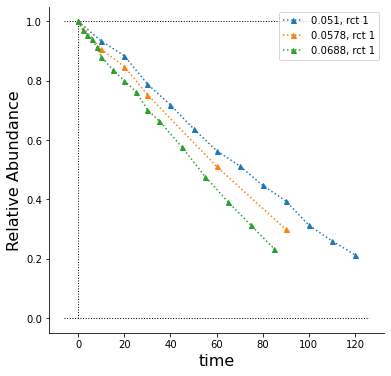

In [7]:
# [0.0510,0.0578,0.0688,0.0750,0.104,0.125,0.127,0.142]
concs = [conc.value for conc in concentrations]
rxn_idxs = [sheet_names.index(val) for val in rxns.value]   # [0, 1]
species = [rct_labels.index(val) for val in rcts.value]  # [0,1]
normalization_method = "MV"

selected = select_data(raw_data, rxn_idxs, species)

totals = get_sheet_totals(normalization_method, selected)
norm_data = normalize_columns(selected, totals)
graph1=plot_vtna(norm_data, concs, order=0, marker_shape="^", 
                  linestyle=':', markersize=5, guide_lines=True)

In [19]:
#function which creates an interactive plot for user to zero their data and smooth datapoints
#inner function only passes variables assigned to widgets
#outer function allows interactive function to be used multpile times
def interact_smoother(sheetnorm, maxtime, title, color):
    def plot_smoothing(windowsize,zero_translate):
        plt.figure(figsize=(9,5))
        for i,col in enumerate(sheetnorm.columns):
            if i > 0:
                orig = plt.scatter(sheetnorm.iloc[:,0], sheetnorm[col], marker='.', 
                         s=14, color='k', alpha = 0.4, label='original')
                sheet_final = (sheetnorm[col]).rolling(windowsize, center=True).mean()
                smooth = plt.scatter(sheetnorm.iloc[:,0]+zero_translate, sheet_final, marker='.', 
                         s=14, color=color, label='smoother')
                plt.xlim((-maxtime/12,maxtime/4))
        plt.vlines(0, 0, 1., linestyle=':', linewidth = 1, color = 'k')
        plt.hlines(0, -maxtime/12,maxtime/4, linestyle=':', linewidth = 1, color = 'k')
        plt.hlines(1, -maxtime/12,maxtime/4, linestyle=':', linewidth = 1, color = 'k')
        plt.title(title, fontsize = 16)
        plt.xlabel('time', fontsize = 16)
        plt.ylabel('Relative Abundance', fontsize = 16)
        plt.legend((orig, smooth), ('original', 'new plot'), loc = 'center right')
        plt.tight_layout()
        plt.show()
    return interactive(plot_smoothing, windowsize=widgets.IntSlider(min=1, max=80, step=3, value=1, 
                                                      description = 'smoothing', continuous_update=False), 
                       zero_translate=widgets.FloatSlider(min=-maxtime/4, max=0, step=0.05, value=0,
                                                        description='set t=0', continuous_update=False))

In [21]:
#find max time to scale axes
maxtime = get_max_times(norm_data)

plot_smoothed = []
for i in range(len(norm_data)):
    plot_smoothed.append(interact_smoother(norm_data[i], maxtime[i], 'Reaction {}'.format(i+1), 'r'))
    display(plot_smoothed[-1])


interactive(children=(IntSlider(value=1, continuous_update=False, description='smoothing', max=80, min=1, step…

interactive(children=(IntSlider(value=1, continuous_update=False, description='smoothing', max=80, min=1, step…

interactive(children=(IntSlider(value=1, continuous_update=False, description='smoothing', max=80, min=1, step…

In [ ]:
#save adjustment values
zeroed_time = []
window = []
for i in range(len(xl.sheet_names)):
    zeroed_time.append(plot_smoothed[i].children[1].value)
    window.append(plot_smoothed[i].children[0].value)

#Adjust t0 in normalized sheets
Rzeroed = []
for i in range(len(xl.sheet_names)):
    Rzeroed.append(Rnorm[i].copy())
    Rzeroed[i].iloc[:,0]=(Rnorm[i].iloc[:,0] + zeroed_time[i])


In [ ]:
#interactive plot to set time normalization
def interact_transform(Rzeroed, conc, window):
    def transform_plot(rxn_order):
        plt.figure(figsize=(10,7))
        sheet_final = []
        t_vtna = []
        for i in range(len(Rzeroed)):
            for j,col in enumerate(Rzeroed[i].columns):
                if j > 0:
                    sheet_final.append(Rzeroed[i][col].rolling(window[i]).mean())
                    t_vtna.append(Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order)
                    plt.scatter(t_vtna[i], sheet_final[i], marker='.',s = 15, color = 'r')
        val = []
        for i in range(len(Rzeroed)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        plt.title('VTNA with {}. Order Treatment'.format(rxn_order))
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(transform_plot, 
                        rxn_order = ipywidgets.FloatSlider(min=0., max=3., step=0.01, value=0, 
                                                           description='Order', continuous_update=False))

In [ ]:
#interactive plot to set time normalization
def interact_transform(Rzeroed, conc, window):
    def transform_plot(rxn_order):
        plt.figure(figsize=(10,7))
        sheet_final = []
        t_vtna = []
        for i in range(len(Rzeroed)):
            for j,col in enumerate(Rzeroed[i].columns):
                if j > 0:
                    #sheet_final.append(Rzeroed[i][col].rolling(window[i]).mean())
                    #t_vtna.append(Rzeroed[i].loc[:,0]*float(conc[i])**rxn_order)
                    t_vtna = Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order
                    smoothed = Rzeroed[i][col].rolling(window[i]).mean()
                    plt.scatter(t_vtna, smoothed, marker='.',s = 15)
        val = []
        for i in range(len(Rzeroed)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        plt.title('VTNA with {}. Order Treatment'.format(rxn_order))
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(transform_plot, 
                        rxn_order = ipywidgets.FloatSlider(min=0., max=3., step=0.01, value=0, 
                                                           description='Order', continuous_update=False))



In [ ]:
trans = interact_transform(Rzeroed, conc, window)
display(trans)

In [ ]:
order = trans.children[0].value
print("Your Reaction is {}. Order in Reagent\n".format(order))

In [ ]:
#generate a final plot
#good formatting starts here
palletteA = ["#003267","#12a4f1","#808fbd"]
palletteB = ["#e5de44","#ef810e","#a73232"]
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
palletteC = palletteA + palletteB
palletteD = ["#e5de44","#fbc316","#ff9a00","#ef810e",'#005DFF','#2776FF','#4689FF','#669DFF','#7EACFF']
plt.figure(figsize=(5,5))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h])**order
            smoothed = Rzeroed[h][col].rolling(window[h]).mean()
            plt.plot(t_vtna, smoothed, linestyle = ':', marker='.',markersize = 8, color = palletteD[h])
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime)
plt.ylim(0,1.02)
plt.xlim(0,6.5)
plt.ylabel('Relative Abundance')
plt.xlabel('[Zr cat]$^{{{}}}$dt'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
#plt.rc('font', size=20)
plt.savefig('VTNA_rawplot.png', dpi=200, filetype = 'png')
frame1 = plt.gca()
frame1.spines['top'].set_visible(False)
frame1.spines['right'].set_visible(False)
#plt.legend(frameon=False)
plt.savefig('hydroamination_1storder.png', dpi=200, filetype = 'png')

plt.show()


In [ ]:
#original
plt.figure(figsize=(5,5))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            t_vtna = Rzeroed[h].iloc[:,0]#*float(conc[h])**order
            smoothed = Rzeroed[h][col].rolling(window[h]).mean()
            plt.plot(t_vtna, smoothed, linestyle = ':', marker='.',markersize = 8, color = palletteD[h], label = concs[h])
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.ylim(0,1.02)
plt.xlim(0,125)
#plt.xlim(-endtime/10, endtime)
plt.ylabel('[c]/[c]$_0$')
plt.xlabel('$t$ (minutes)'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
plt.savefig('VTNA_rawplot.png', dpi=200, filetype = 'png')
frame1 = plt.gca()
frame1.spines['top'].set_visible(False)
frame1.spines['right'].set_visible(False)
plt.legend(frameon=False, fontsize = 12)
plt.savefig('hydroam_overlay.png', dpi=200, filetype = 'png')

plt.show()

In [ ]:
#save the new data
data_out = []
for i in range(len(xl.sheet_names)):
    #data_out.append(pd.concat([t_vtna[h],Rzeroed[h]], axis=1))
    data_out.append([t_vtna,Rzeroed])
with open("data_out.txt", 'w') as output:
    for row in data_out:
        output.write(str(row) + '\n')

In [ ]:
#catalyst poisoning
#marked by suppressed activity at low concentrations
#treat by lowering the effective concentration
#function which creates interactive plot
#must know order of reaction
def interact_poisoning(Rzeroed, conc, rxn_order, window):
    conc_min = min(conc)
    def poisoned_plot(poison):
        plt.figure(figsize=(10,7))
        R_final = []
        t_vtna = []
        for h in range(len(xl.sheet_names)):
            for i,col in enumerate(Rzeroed[h].columns):
                if i > 0:
                    R_final = Rzeroed[h][col].rolling(window[h]).mean()
                    t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order
                    plt.plot(t_vtna, R_final, linestyle = '--', marker='.', markersize = 10)
        val = []
        for i in range(len(xl.sheet_names)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        #plt.title('concentration units poisoning')
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Catalyst-{}]$^{{{}}}$dt'.format(str(poison),str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(poisoned_plot, 
                        poison = ipywidgets.FloatSlider(min=0., max=conc_min, step=conc_min/500., value=0.000, 
                                                           description='{} - Posion'.format(conc_min), continuous_update=False))


In [ ]:
poisonedor = interact_poisoning(Rzeroed, conc, order, window)
display(poisonedor)

In [ ]:
poison = poisonedor.children[0].value
poison

In [ ]:
plt.figure(figsize=(5,5))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order
            smoothed = Rzeroed[h][col].rolling(window[h]).mean()
            plt.plot(t_vtna, smoothed, linestyle = ':', marker ='.', markersize = 8, color = palletteD[h])
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime)
plt.ylabel('Relative Abundance')
plt.xlabel('([Zr cat]-0.0154 mM)$^{{{}}}$dt'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
#plt.rc('font', size=20)
plt.savefig('VTNA_rawplot.png', dpi=200, filetype = 'png')
frame1 = plt.gca()
frame1.spines['top'].set_visible(False)
frame1.spines['right'].set_visible(False)
#plt.legend(frameon=False)
plt.savefig('hydroam_poisoncorrected.png', dpi=200, filetype = 'png')

plt.show()

In [ ]:
#generate a final plot
plt.figure(figsize=(10,7))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            R_final = Rzeroed[h][col].rolling(window[h]).mean()
            t_vtna = Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order
            plt.scatter(t_vtna, R_final, marker='.', s = 60)
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime)
plt.ylabel('Relative Abundance')
plt.xlabel('([Co$_2$(CO)$_8$] - {} mM) $^{{{}}}$ dt'.format(poison,str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
plt.rc('font', size=17)
#plt.savefig("329_vtna.png", dpi = 200)
plt.show()
